### Protein sequence classification 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns  
from transformers import AutoTokenizer, AutoModel 

In [2]:
from datasets import load_dataset 
ds = load_dataset("proteinea/deeploc") 

In [3]:
ds 

DatasetDict({
    train: Dataset({
        features: ['input', 'loc', 'membrane'],
        num_rows: 6622
    })
    test: Dataset({
        features: ['input', 'loc', 'membrane'],
        num_rows: 1842
    })
})

In [4]:
train_ds = ds['train'] 
test_ds = ds['test'] 

In [5]:
small_train_ds = train_ds.shuffle(seed=42).select(range(500))  

In [6]:
small_train_ds[0]

{'input': 'MSVIGSKSCIFSVARYTRENEKSSCFTSINKKSSLDLRFPRNLAGVSCKFSGENPGTNGVSLSSKNKMEDYNTAMKRLMRSPYEYHHDLGMNYTLIRDELIVGSQPQKPEDIDHLKQEQNVAYILNLQQDKDIEYWGIDLDSIVRRCKELGIRHMRRPAKDFDPLSLRSQLPKAVSSLEWAVSEGKGRVYVHCSAGLGRAPGVSIAYMYWFCDMNLNTAYDTLVSKRPCGPNKGAIRGATYDLAKNDPWKEPFESLPENAFEDIADWERKLIQERVRALRGT',
 'loc': 'Plastid',
 'membrane': 'U'}

In [7]:
##embedding models
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd",do_lower_case=False)
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")   

In [8]:
#tokenize sequences
def tokenize_sequences(examples):
    sequences = [" ".join(list(seq)) for seq in examples['input']]
    return tokenizer(sequences,return_tensors="pt",padding=True,truncation=True) 

small_train_ds = small_train_ds.map(tokenize_sequences, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
small_train_ds[0]

{'input': 'MSVIGSKSCIFSVARYTRENEKSSCFTSINKKSSLDLRFPRNLAGVSCKFSGENPGTNGVSLSSKNKMEDYNTAMKRLMRSPYEYHHDLGMNYTLIRDELIVGSQPQKPEDIDHLKQEQNVAYILNLQQDKDIEYWGIDLDSIVRRCKELGIRHMRRPAKDFDPLSLRSQLPKAVSSLEWAVSEGKGRVYVHCSAGLGRAPGVSIAYMYWFCDMNLNTAYDTLVSKRPCGPNKGAIRGATYDLAKNDPWKEPFESLPENAFEDIADWERKLIQERVRALRGT',
 'loc': 'Plastid',
 'membrane': 'U',
 'input_ids': [2,
  21,
  10,
  8,
  11,
  7,
  10,
  12,
  10,
  23,
  11,
  19,
  10,
  8,
  6,
  13,
  20,
  15,
  13,
  9,
  17,
  9,
  12,
  10,
  10,
  23,
  19,
  15,
  10,
  11,
  17,
  12,
  12,
  10,
  10,
  5,
  14,
  5,
  13,
  19,
  16,
  13,
  17,
  5,
  6,
  7,
  8,
  10,
  23,
  12,
  19,
  10,
  7,
  9,
  17,
  16,
  7,
  15,
  17,
  7,
  8,
  10,
  5,
  10,
  10,
  12,
  17,
  12,
  21,
  9,
  14,
  20,
  17,
  15,
  6,
  21,
  12,
  13,
  5,
  21,
  13,
  10,
  16,
  20,
  9,
  20,
  22,
  22,
  14,
  5,
  7,
  21,
  17,
  20,
  15,
  5,
  11,
  13,
  14,
  9,
  5,
  11,
  8,
  7,
  10,
  18,
  16,
  18,
  12,
  16,
  9,
  14,
  11,
  14,
 

In [10]:
#get embeddings for the tokens
import torch 
from torch.utils.data import DataLoader 

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
    }

train_loader = DataLoader(small_train_ds, batch_size=8, collate_fn=collate_fn)


In [11]:
sample_batch = next(iter(train_loader)) 
print(sample_batch.keys())

dict_keys(['input_ids', 'attention_mask'])


In [14]:
all_embeddings = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
with torch.no_grad():
    for batch in train_loader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        outputs = model(**inputs) 
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(cls_embeddings.detach().cpu().numpy()) 

all_embeddings = np.concatenate(all_embeddings, axis=0) 

In [15]:
all_embeddings

array([[ 0.08726697,  0.03858672,  0.11149974, ..., -0.00522191,
        -0.05769072, -0.10050102],
       [ 0.06031318,  0.03156782,  0.07220025, ...,  0.00708416,
        -0.04954385, -0.06212676],
       [ 0.05845402, -0.02512769,  0.0879981 , ..., -0.06544561,
        -0.02758044, -0.07710952],
       ...,
       [ 0.09965329,  0.00925808,  0.04466364, ..., -0.0077017 ,
        -0.02084242, -0.05642685],
       [ 0.14012982,  0.04824141,  0.13922209, ...,  0.01915572,
        -0.06487802, -0.06482274],
       [ 0.05229184, -0.02618638,  0.04773392, ...,  0.08023422,
        -0.02120796, -0.02327284]], dtype=float32)

In [16]:
all_embeddings.shape 

(500, 1024)

In [22]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()  
y = label_encoder.fit_transform(small_train_ds['loc']) 
#test_labels = label_encoder.transform(test_ds['loc'])

clf_models = {'RandomForest': RandomForestClassifier(), 'XGBoost': XGBClassifier()}
X = all_embeddings

In [24]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y) 

In [25]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(400, 1024) (100, 1024)
(400,) (100,)


In [26]:
for model_name, model in clf_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model_name}:')
    print(classification_report(y_test, y_pred,target_names=label_encoder.classes_))
    print(accuracy_score(y_test, y_pred))
    print(); 

RandomForest:
                       precision    recall  f1-score   support

        Cell.membrane       0.00      0.00      0.00         7
            Cytoplasm       0.33      0.42      0.37        19
Endoplasmic.reticulum       0.00      0.00      0.00         7
        Extracellular       0.80      0.57      0.67         7
      Golgi.apparatus       0.00      0.00      0.00         3
     Lysosome/Vacuole       0.00      0.00      0.00         1
        Mitochondrion       0.50      0.69      0.58        13
              Nucleus       0.60      0.83      0.70        35
              Plastid       0.75      0.38      0.50         8

             accuracy                           0.53       100
            macro avg       0.33      0.32      0.31       100
         weighted avg       0.46      0.53      0.48       100

0.53



c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

XGBoost:
                       precision    recall  f1-score   support

        Cell.membrane       0.25      0.14      0.18         7
            Cytoplasm       0.38      0.53      0.44        19
Endoplasmic.reticulum       0.40      0.29      0.33         7
        Extracellular       0.71      0.71      0.71         7
      Golgi.apparatus       0.00      0.00      0.00         3
     Lysosome/Vacuole       0.00      0.00      0.00         1
        Mitochondrion       0.70      0.54      0.61        13
              Nucleus       0.65      0.74      0.69        35
              Plastid       0.71      0.62      0.67         8

             accuracy                           0.56       100
            macro avg       0.42      0.40      0.40       100
         weighted avg       0.54      0.56      0.55       100

0.56



c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

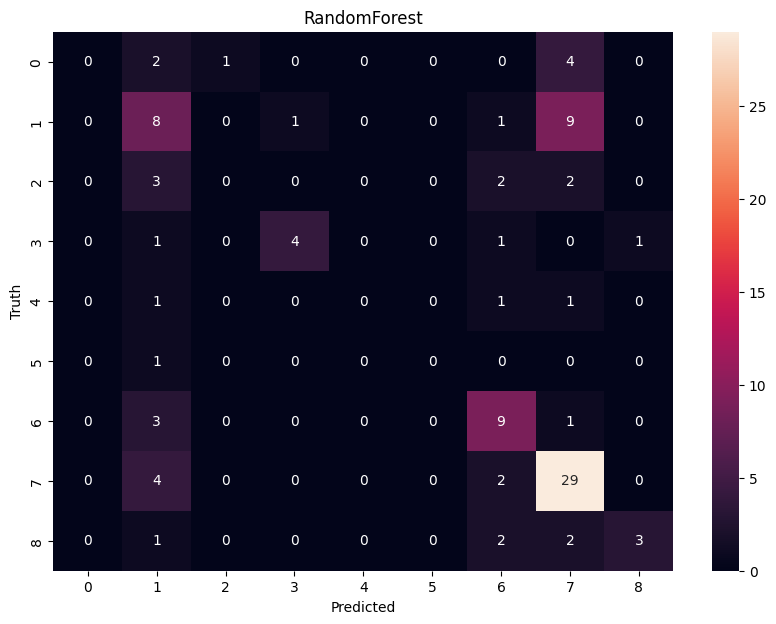

RandomForest:



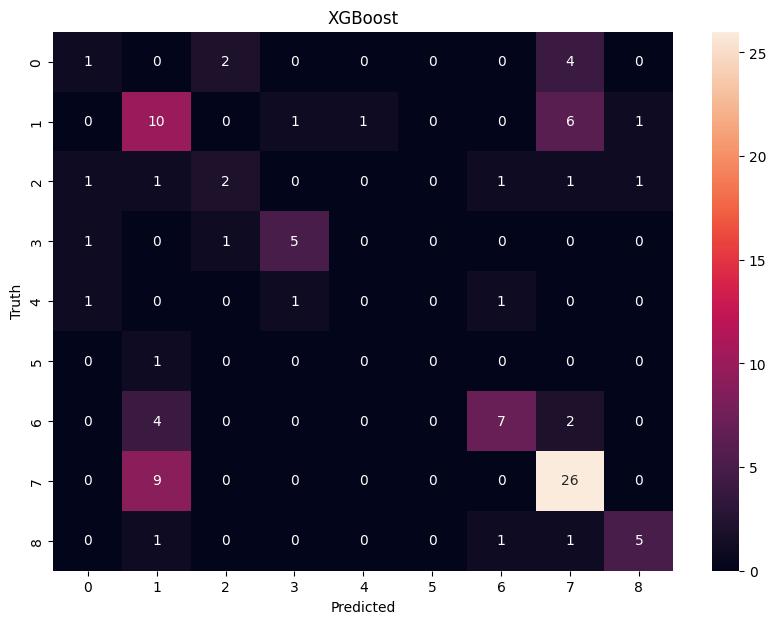

XGBoost:



In [30]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
for model_name, model in clf_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{model_name}')
    plt.show()
    print(f'{model_name}:')
    print(); 
